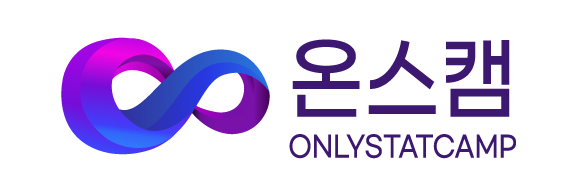

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.15.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    # tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=1024 * 3.5)])

In [3]:
# !pip install -U keras-cv==0.5.0
import keras_cv

Using TensorFlow backend


In [4]:
print(keras_cv.__version__)

0.8.2


In [5]:
import tensorflow_hub as hub

In [6]:
print(hub.__version__)

0.16.1


## CIFAR10 데이터셋 임포트하기

CIFAR10 데이터세트에는 10개 클래스에 60,000개의 컬러 이미지가 포함되어 있으며 각 클래스에는 6,000개의 이미지가 있습니다. 이 데이터세트는 50,000개의 훈련 이미지와 10,000개의 테스트 이미지로 나뉩니다. 클래스는 상호 배타적이며 서로 겹치지 않습니다.

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~1 사이라는 것을 알 수 있습니다:

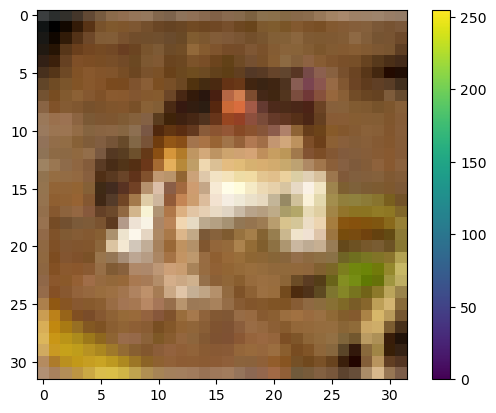

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. *훈련 세트*와 *테스트 세트*를 동일한 방식으로 전처리하는 것이 중요합니다:

In [10]:
train_images = train_images.astype(np.float32)
train_images = train_images / 255.0

test_images = test_images.astype(np.float32)
test_images = test_images / 255.0

In [11]:
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

In [12]:
IMG_SIZE = 32 * 3

In [13]:
IMG_SIZE

96

*훈련 세트*에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 보죠. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

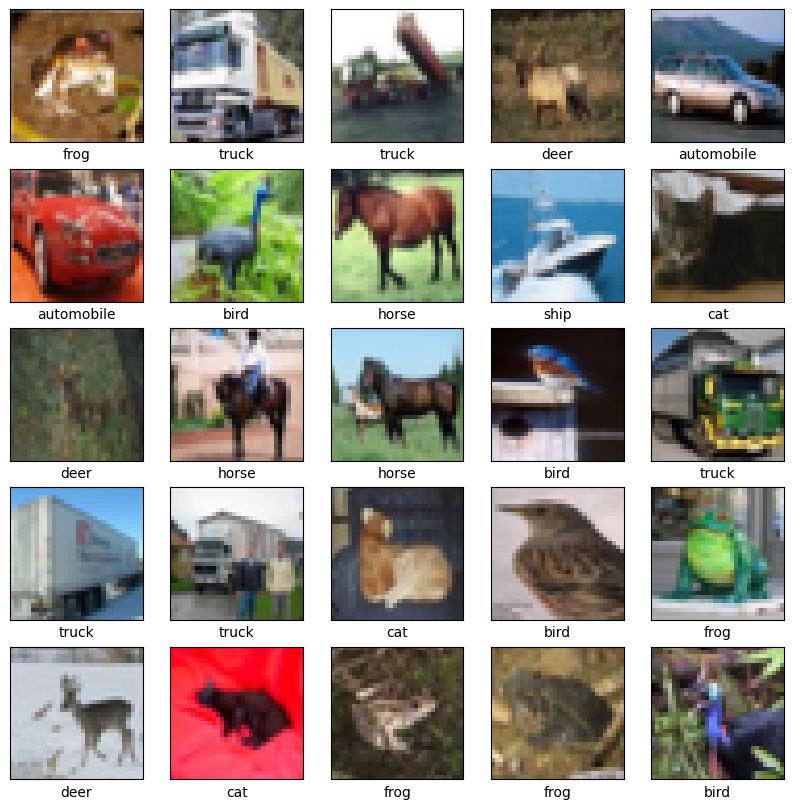

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## KerasCV

https://keras.io/keras_cv/

### keras_cv.layers.RandAugmen

RandAugment는 입력 이미지에 대해 Rand Augment 작업을 수행합니다.

이 레이어는 올인원 이미지 확대 레이어로 생각할 수 있습니다. 이 계층에서 구현된 정책은 광범위하게 벤치마킹되었으며 다양한 데이터 세트에 효과적입니다.

In [15]:
rand_augment = keras_cv.layers.RandAugment(value_range=(0, 1))
x_test = rand_augment(test_images[:25])

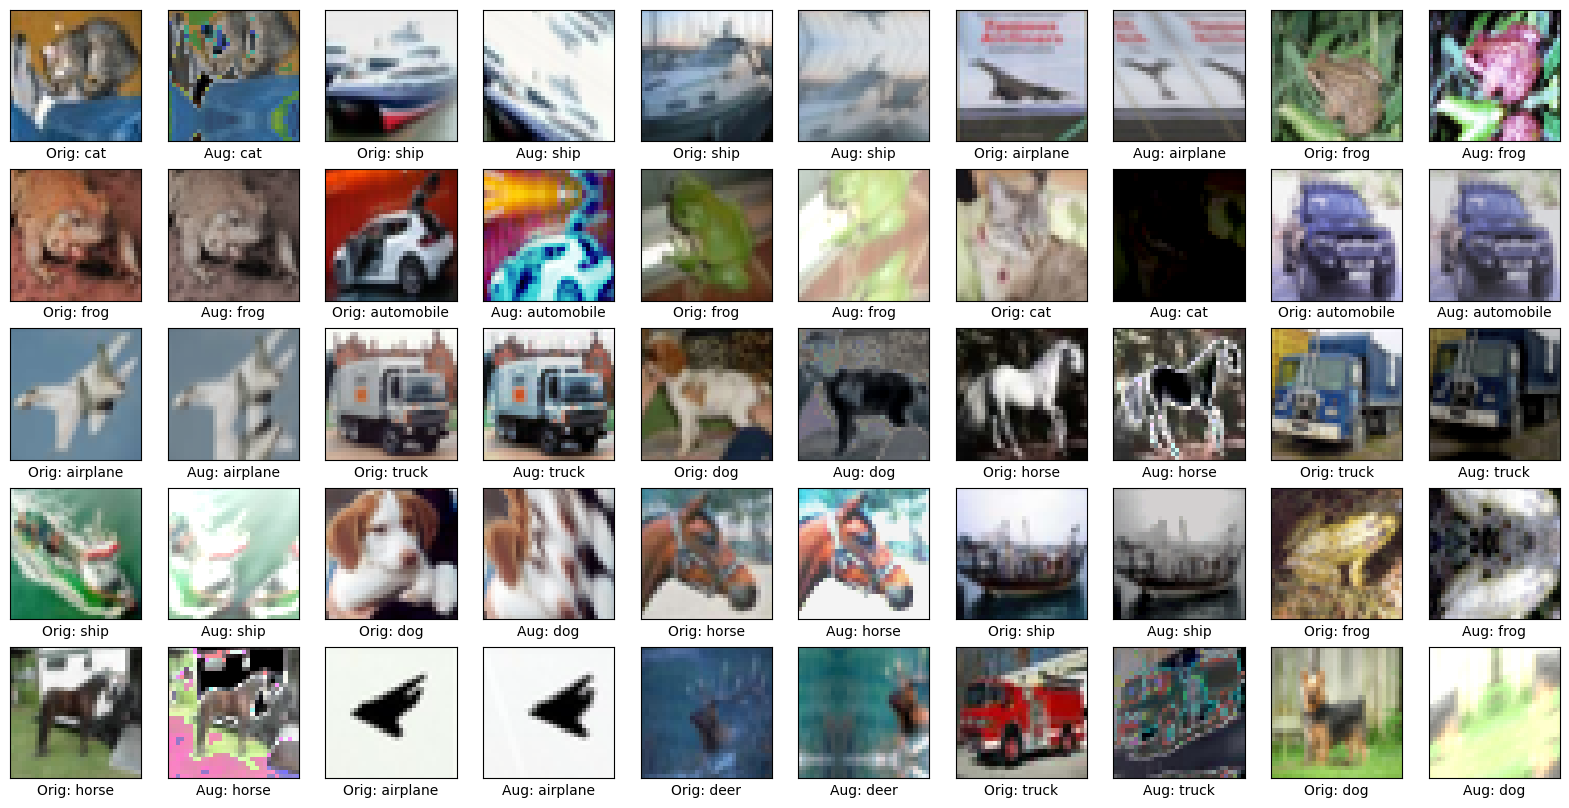

In [16]:
plt.figure(figsize=(20, 10))
for i in range(25):
    
    plt.subplot(5, 10, i*2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    plt.xlabel("Orig: "+ class_names[test_labels[i][0]])
    
    plt.subplot(5, 10, i*2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.xlabel("Aug: "+ class_names[test_labels[i][0]])
    
plt.show()

## Datasets

In [17]:
BATCH_SIZE = 128

### train datasets

In [18]:
def image_preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=(IMG_SIZE, IMG_SIZE))
    
    label = tf.cast(label, tf.int32)
    return image, label

In [19]:
randaugment = keras_cv.layers.RandAugment(value_range=(0, 1))

def image_augmentation(image, label):
    image = randaugment(image)
    return image, label

In [20]:
datasets_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

datasets_train = datasets_train.shuffle(buffer_size=len(train_labels))
datasets_train = datasets_train.batch(batch_size=BATCH_SIZE)

datasets_train = datasets_train.map(image_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
datasets_train = datasets_train.map(image_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

datasets_train = datasets_train.prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
datasets_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

### test datasets

In [22]:
datasets_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [23]:
datasets_test = datasets_test.batch(batch_size=BATCH_SIZE)

datasets_test = datasets_test.map(image_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

datasets_test = datasets_test.prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
datasets_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

## https://keras.io/api/applications/

Keras 애플리케이션은 사전 훈련된 가중치와 함께 사용할 수 있는 딥 러닝 모델입니다. 이러한 모델은 예측, 특징 추출 및 미세 조정에 사용될 수 있습니다.

모델을 인스턴스화할 때 가중치가 자동으로 다운로드됩니다. 에 저장되어 있습니다 ~/.keras/models/.

인스턴스화 시 Keras 구성 파일에 설정된 이미지 데이터 형식에 따라 모델이 구축됩니다 ~/.keras/keras.json. 예를 들어, 을 설정한 경우 image_data_format=channels_last이 저장소에서 로드된 모든 모델은 "높이-너비-깊이" 데이터 형식 규칙에 따라 구축됩니다.

<table>
<thead>
<tr>
<th>Model</th>
<th style="text-align: right;">Size (MB)</th>
<th style="text-align: right;">Top-1 Accuracy</th>
<th style="text-align: right;">Top-5 Accuracy</th>
<th style="text-align: right;">Parameters</th>
<th style="text-align: right;">Depth</th>
<th style="text-align: right;">Time (ms) per inference step (CPU)</th>
<th style="text-align: right;">Time (ms) per inference step (GPU)</th>
</tr>
</thead>
<tbody>
<tr>
<td><a href="xception">Xception</a></td>
<td style="text-align: right;">88</td>
<td style="text-align: right;">79.0%</td>
<td style="text-align: right;">94.5%</td>
<td style="text-align: right;">22.9M</td>
<td style="text-align: right;">81</td>
<td style="text-align: right;">109.4</td>
<td style="text-align: right;">8.1</td>
</tr>
<tr>
<td><a href="vgg/#vgg16-function">VGG16</a></td>
<td style="text-align: right;">528</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.1%</td>
<td style="text-align: right;">138.4M</td>
<td style="text-align: right;">16</td>
<td style="text-align: right;">69.5</td>
<td style="text-align: right;">4.2</td>
</tr>
<tr>
<td><a href="vgg/#vgg19-function">VGG19</a></td>
<td style="text-align: right;">549</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.0%</td>
<td style="text-align: right;">143.7M</td>
<td style="text-align: right;">19</td>
<td style="text-align: right;">84.8</td>
<td style="text-align: right;">4.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet50-function">ResNet50</a></td>
<td style="text-align: right;">98</td>
<td style="text-align: right;">74.9%</td>
<td style="text-align: right;">92.1%</td>
<td style="text-align: right;">25.6M</td>
<td style="text-align: right;">107</td>
<td style="text-align: right;">58.2</td>
<td style="text-align: right;">4.6</td>
</tr>
<tr>
<td><a href="resnet/#resnet50v2-function">ResNet50V2</a></td>
<td style="text-align: right;">98</td>
<td style="text-align: right;">76.0%</td>
<td style="text-align: right;">93.0%</td>
<td style="text-align: right;">25.6M</td>
<td style="text-align: right;">103</td>
<td style="text-align: right;">45.6</td>
<td style="text-align: right;">4.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet101-function">ResNet101</a></td>
<td style="text-align: right;">171</td>
<td style="text-align: right;">76.4%</td>
<td style="text-align: right;">92.8%</td>
<td style="text-align: right;">44.7M</td>
<td style="text-align: right;">209</td>
<td style="text-align: right;">89.6</td>
<td style="text-align: right;">5.2</td>
</tr>
<tr>
<td><a href="resnet/#resnet101v2-function">ResNet101V2</a></td>
<td style="text-align: right;">171</td>
<td style="text-align: right;">77.2%</td>
<td style="text-align: right;">93.8%</td>
<td style="text-align: right;">44.7M</td>
<td style="text-align: right;">205</td>
<td style="text-align: right;">72.7</td>
<td style="text-align: right;">5.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet152-function">ResNet152</a></td>
<td style="text-align: right;">232</td>
<td style="text-align: right;">76.6%</td>
<td style="text-align: right;">93.1%</td>
<td style="text-align: right;">60.4M</td>
<td style="text-align: right;">311</td>
<td style="text-align: right;">127.4</td>
<td style="text-align: right;">6.5</td>
</tr>
<tr>
<td><a href="resnet/#resnet152v2-function">ResNet152V2</a></td>
<td style="text-align: right;">232</td>
<td style="text-align: right;">78.0%</td>
<td style="text-align: right;">94.2%</td>
<td style="text-align: right;">60.4M</td>
<td style="text-align: right;">307</td>
<td style="text-align: right;">107.5</td>
<td style="text-align: right;">6.6</td>
</tr>
<tr>
<td><a href="inceptionv3">InceptionV3</a></td>
<td style="text-align: right;">92</td>
<td style="text-align: right;">77.9%</td>
<td style="text-align: right;">93.7%</td>
<td style="text-align: right;">23.9M</td>
<td style="text-align: right;">189</td>
<td style="text-align: right;">42.2</td>
<td style="text-align: right;">6.9</td>
</tr>
<tr>
<td><a href="inceptionresnetv2">InceptionResNetV2</a></td>
<td style="text-align: right;">215</td>
<td style="text-align: right;">80.3%</td>
<td style="text-align: right;">95.3%</td>
<td style="text-align: right;">55.9M</td>
<td style="text-align: right;">449</td>
<td style="text-align: right;">130.2</td>
<td style="text-align: right;">10.0</td>
</tr>
<tr>
<td><a href="mobilenet">MobileNet</a></td>
<td style="text-align: right;">16</td>
<td style="text-align: right;">70.4%</td>
<td style="text-align: right;">89.5%</td>
<td style="text-align: right;">4.3M</td>
<td style="text-align: right;">55</td>
<td style="text-align: right;">22.6</td>
<td style="text-align: right;">3.4</td>
</tr>
<tr>
<td><a href="mobilenet/#mobilenetv2-function">MobileNetV2</a></td>
<td style="text-align: right;">14</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.1%</td>
<td style="text-align: right;">3.5M</td>
<td style="text-align: right;">105</td>
<td style="text-align: right;">25.9</td>
<td style="text-align: right;">3.8</td>
</tr>
<tr>
<td><a href="densenet/#densenet121-function">DenseNet121</a></td>
<td style="text-align: right;">33</td>
<td style="text-align: right;">75.0%</td>
<td style="text-align: right;">92.3%</td>
<td style="text-align: right;">8.1M</td>
<td style="text-align: right;">242</td>
<td style="text-align: right;">77.1</td>
<td style="text-align: right;">5.4</td>
</tr>
<tr>
<td><a href="densenet/#densenet169-function">DenseNet169</a></td>
<td style="text-align: right;">57</td>
<td style="text-align: right;">76.2%</td>
<td style="text-align: right;">93.2%</td>
<td style="text-align: right;">14.3M</td>
<td style="text-align: right;">338</td>
<td style="text-align: right;">96.4</td>
<td style="text-align: right;">6.3</td>
</tr>
<tr>
<td><a href="densenet/#densenet201-function">DenseNet201</a></td>
<td style="text-align: right;">80</td>
<td style="text-align: right;">77.3%</td>
<td style="text-align: right;">93.6%</td>
<td style="text-align: right;">20.2M</td>
<td style="text-align: right;">402</td>
<td style="text-align: right;">127.2</td>
<td style="text-align: right;">6.7</td>
</tr>
<tr>
<td><a href="nasnet/#nasnetmobile-function">NASNetMobile</a></td>
<td style="text-align: right;">23</td>
<td style="text-align: right;">74.4%</td>
<td style="text-align: right;">91.9%</td>
<td style="text-align: right;">5.3M</td>
<td style="text-align: right;">389</td>
<td style="text-align: right;">27.0</td>
<td style="text-align: right;">6.7</td>
</tr>
<tr>
<td><a href="nasnet/#nasnetlarge-function">NASNetLarge</a></td>
<td style="text-align: right;">343</td>
<td style="text-align: right;">82.5%</td>
<td style="text-align: right;">96.0%</td>
<td style="text-align: right;">88.9M</td>
<td style="text-align: right;">533</td>
<td style="text-align: right;">344.5</td>
<td style="text-align: right;">20.0</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb0-function">EfficientNetB0</a></td>
<td style="text-align: right;">29</td>
<td style="text-align: right;">77.1%</td>
<td style="text-align: right;">93.3%</td>
<td style="text-align: right;">5.3M</td>
<td style="text-align: right;">132</td>
<td style="text-align: right;">46.0</td>
<td style="text-align: right;">4.9</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb1-function">EfficientNetB1</a></td>
<td style="text-align: right;">31</td>
<td style="text-align: right;">79.1%</td>
<td style="text-align: right;">94.4%</td>
<td style="text-align: right;">7.9M</td>
<td style="text-align: right;">186</td>
<td style="text-align: right;">60.2</td>
<td style="text-align: right;">5.6</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb2-function">EfficientNetB2</a></td>
<td style="text-align: right;">36</td>
<td style="text-align: right;">80.1%</td>
<td style="text-align: right;">94.9%</td>
<td style="text-align: right;">9.2M</td>
<td style="text-align: right;">186</td>
<td style="text-align: right;">80.8</td>
<td style="text-align: right;">6.5</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb3-function">EfficientNetB3</a></td>
<td style="text-align: right;">48</td>
<td style="text-align: right;">81.6%</td>
<td style="text-align: right;">95.7%</td>
<td style="text-align: right;">12.3M</td>
<td style="text-align: right;">210</td>
<td style="text-align: right;">140.0</td>
<td style="text-align: right;">8.8</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb4-function">EfficientNetB4</a></td>
<td style="text-align: right;">75</td>
<td style="text-align: right;">82.9%</td>
<td style="text-align: right;">96.4%</td>
<td style="text-align: right;">19.5M</td>
<td style="text-align: right;">258</td>
<td style="text-align: right;">308.3</td>
<td style="text-align: right;">15.1</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb5-function">EfficientNetB5</a></td>
<td style="text-align: right;">118</td>
<td style="text-align: right;">83.6%</td>
<td style="text-align: right;">96.7%</td>
<td style="text-align: right;">30.6M</td>
<td style="text-align: right;">312</td>
<td style="text-align: right;">579.2</td>
<td style="text-align: right;">25.3</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb6-function">EfficientNetB6</a></td>
<td style="text-align: right;">166</td>
<td style="text-align: right;">84.0%</td>
<td style="text-align: right;">96.8%</td>
<td style="text-align: right;">43.3M</td>
<td style="text-align: right;">360</td>
<td style="text-align: right;">958.1</td>
<td style="text-align: right;">40.4</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb7-function">EfficientNetB7</a></td>
<td style="text-align: right;">256</td>
<td style="text-align: right;">84.3%</td>
<td style="text-align: right;">97.0%</td>
<td style="text-align: right;">66.7M</td>
<td style="text-align: right;">438</td>
<td style="text-align: right;">1578.9</td>
<td style="text-align: right;">61.6</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b0-function">EfficientNetV2B0</a></td>
<td style="text-align: right;">29</td>
<td style="text-align: right;">78.7%</td>
<td style="text-align: right;">94.3%</td>
<td style="text-align: right;">7.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b1-function">EfficientNetV2B1</a></td>
<td style="text-align: right;">34</td>
<td style="text-align: right;">79.8%</td>
<td style="text-align: right;">95.0%</td>
<td style="text-align: right;">8.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b2-function">EfficientNetV2B2</a></td>
<td style="text-align: right;">42</td>
<td style="text-align: right;">80.5%</td>
<td style="text-align: right;">95.1%</td>
<td style="text-align: right;">10.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b3-function">EfficientNetV2B3</a></td>
<td style="text-align: right;">59</td>
<td style="text-align: right;">82.0%</td>
<td style="text-align: right;">95.8%</td>
<td style="text-align: right;">14.5M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2s-function">EfficientNetV2S</a></td>
<td style="text-align: right;">88</td>
<td style="text-align: right;">83.9%</td>
<td style="text-align: right;">96.7%</td>
<td style="text-align: right;">21.6M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2m-function">EfficientNetV2M</a></td>
<td style="text-align: right;">220</td>
<td style="text-align: right;">85.3%</td>
<td style="text-align: right;">97.4%</td>
<td style="text-align: right;">54.4M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2l-function">EfficientNetV2L</a></td>
<td style="text-align: right;">479</td>
<td style="text-align: right;">85.7%</td>
<td style="text-align: right;">97.5%</td>
<td style="text-align: right;">119.0M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnexttiny-function">ConvNeXtTiny</a></td>
<td style="text-align: right;">109.42</td>
<td style="text-align: right;">81.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">28.6M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextsmall-function">ConvNeXtSmall</a></td>
<td style="text-align: right;">192.29</td>
<td style="text-align: right;">82.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">50.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextbase-function">ConvNeXtBase</a></td>
<td style="text-align: right;">338.58</td>
<td style="text-align: right;">85.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">88.5M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextlarge-function">ConvNeXtLarge</a></td>
<td style="text-align: right;">755.07</td>
<td style="text-align: right;">86.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">197.7M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextxlarge-function">ConvNeXtXLarge</a></td>
<td style="text-align: right;">1310</td>
<td style="text-align: right;">86.7%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">350.1M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
</tbody>
</table>

### 층 설정

신경망의 기본 빌딩 블록은 [*레이어*](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 입니다. 레이어는 레이어에 공급된 데이터로부터 표현을 추출합니다. 이러한 표현은 당면한 문제에 의미가 있어야 합니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. `tf.keras.layers.Dense`와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

In [25]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [26]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)

In [27]:
input_shape

(96, 96, 3)

### TensorFlow Hub

https://www.kaggle.com/models/google/mobilenet-v2

https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md

In [28]:
model = tf.keras.Sequential([
#     hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/100-96-feature-vector/versions/2", trainable=True, input_shape=input_shape),
    
    hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2",trainable=True,input_shape=input_shape),
    layers.LayerNormalization(),
    tf.keras.layers.Dense(len(class_names), activation='softmax'),
])

In [29]:
model.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 keras_layer (KerasLayer)    (None, 1000)              7200312   Y          
                                                                            
 layer_normalization (Layer  (None, 1000)              2000      Y          
 Normalization)                                                             
                                                                            
 dense (Dense)               (None, 10)                10010     Y          
                                                                            
Total params: 7212322 (27.51 MB)
Trainable params: 7151714 (27.28 MB)
Non-trainable params: 60608 (236.75 KB)
____________________________________________________________________________



### 모델 컴파일

모델을 훈련할 준비가 되기 전에 몇 가지 설정이 더 필요합니다. 다음은 모델의 [*컴파일*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) 단계에서 추가됩니다.

- [*손실 함수*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) - 훈련 중 모델이 얼마나 정확한지 측정합니다. 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화해야 합니다.
- [*옵티마이저*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) - 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식입니다.
- [*메트릭*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) — 훈련 및 테스트 단계를 모니터링하는 데 사용됩니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 *정확도*를 사용합니다.

In [30]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-03),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(),
              ])

In [31]:
model.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 keras_layer (KerasLayer)    (None, 1000)              7200312   Y          
                                                                            
 layer_normalization (Layer  (None, 1000)              2000      Y          
 Normalization)                                                             
                                                                            
 dense (Dense)               (None, 10)                10010     Y          
                                                                            
Total params: 7212322 (27.51 MB)
Trainable params: 7151714 (27.28 MB)
Non-trainable params: 60608 (236.75 KB)
____________________________________________________________________________


In [32]:
for idx, weight in enumerate(sorted(model.weights, key=lambda x: x.name)):
    print("{:<5d}: {}".format(idx, weight.name))

0    : dense/bias:0
1    : dense/kernel:0
2    : efficientnetv2-b0/blocks_0/conv2d/kernel:0
3    : efficientnetv2-b0/blocks_0/tpu_batch_normalization/beta:0
4    : efficientnetv2-b0/blocks_0/tpu_batch_normalization/gamma:0
5    : efficientnetv2-b0/blocks_0/tpu_batch_normalization/moving_mean:0
6    : efficientnetv2-b0/blocks_0/tpu_batch_normalization/moving_variance:0
7    : efficientnetv2-b0/blocks_1/conv2d/kernel:0
8    : efficientnetv2-b0/blocks_1/conv2d_1/kernel:0
9    : efficientnetv2-b0/blocks_1/tpu_batch_normalization/beta:0
10   : efficientnetv2-b0/blocks_1/tpu_batch_normalization/gamma:0
11   : efficientnetv2-b0/blocks_1/tpu_batch_normalization/moving_mean:0
12   : efficientnetv2-b0/blocks_1/tpu_batch_normalization/moving_variance:0
13   : efficientnetv2-b0/blocks_1/tpu_batch_normalization_1/beta:0
14   : efficientnetv2-b0/blocks_1/tpu_batch_normalization_1/gamma:0
15   : efficientnetv2-b0/blocks_1/tpu_batch_normalization_1/moving_mean:0
16   : efficientnetv2-b0/blocks_1/tpu_b

## 모델 훈련

신경망 모델을 훈련하려면 다음 단계가 필요합니다.

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 `train_images`와 `train_labels` 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 `test_images` 배열입니다. 이 예측이 `test_labels` 배열의 레이블과 맞는지 확인합니다.
4. 예측이 `test_labels` 배열의 레이블과 일치하는지 확인합니다.


### 모델 피드

훈련을 시작하려면 [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) 메서드를 호출합니다. 모델을 훈련 데이터에 "맞추기(fit)" 때문에 이렇게 불립니다.

In [33]:
history  = model.fit(datasets_train, epochs=20, validation_data=datasets_test)

Epoch 1/20



391/391 [==============================] - 442s 1s/step - loss: 1.0304 - sparse_categorical_accuracy: 0.6677 - val_loss: 0.3156 - val_sparse_categorical_accuracy: 0.8945
Epoch 2/20
391/391 [==============================] - 443s 1s/step - loss: 0.6895 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.2582 - val_sparse_categorical_accuracy: 0.9122
Epoch 3/20
391/391 [==============================] - 431s 1s/step - loss: 0.6092 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.2252 - val_sparse_categorical_accuracy: 0.9212
Epoch 4/20
391/391 [==============================] - 455s 1s/step - loss: 0.5482 - sparse_categorical_accuracy: 0.8145 - val_loss: 0.2201 - val_sparse_categorical_accuracy: 0.9222
Epoch 5/20
391/391 [==============================] - 428s 1s/step - loss: 0.5212 - sparse_categorical_accuracy: 0.8217 - val_loss: 0.2136 - val_sparse_categorical_accuracy: 0.9263
Epoch 6/20
 39/391 [=>............................] - ETA: 6:01 - loss: 0.5039 - sparse_categorical_accura

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## 미세 조정

### 컨볼루션 베이스 모델 고정하기

In [ ]:
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-03),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(),
              ])

In [ ]:
model.summary(show_trainable=True)

In [ ]:
history_fine  = model.fit(datasets_train, epochs=10, validation_data=datasets_test)

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'] + history_fine.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'] + history_fine.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.plot([19.5, 19.5], [0.5, 1], label='Start Fine Tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')